In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sklearn
from sklearn import tree
from sklearn import preprocessing
from sklearn import metrics
from sklearn import model_selection
import graphviz
import seaborn as sns
import math
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import KernelPCA
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

pd.set_option('display.max_columns', 500)

from google.colab import drive
drive.mount('/content/drive')

data = pd.read_csv('/content/drive/My Drive/machine learning/assignment 2/melbourne-house-prices/cleaned_data.csv') 

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


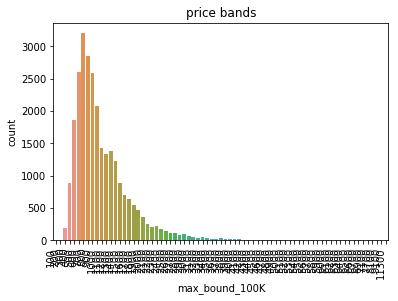

Index(['suburb', 'rooms', 'type_code', 'max_bound_100K', 'price_bands',
       'method_orig', 'method', 'realestate_agent', 'year', 'distance',
       'postcode', 'bedrooms', 'bathrooms', 'car_parks', 'landsize',
       'building_area', 'council_area', 'lattitude', 'longtitude',
       'region_name', 'suburb_property_count'],
      dtype='object')

In [2]:
data_copy = data.copy()

#### explore the target ###
plot = sns.countplot(data_copy['max_bound_100K'])
plot.set_title("price bands")
plot.set_xticklabels(plot.get_xticklabels(), rotation=90, ha="right")
plt.show()

plt.rcParams["figure.figsize"] = (15, 10)

data_copy.columns

In [0]:
# function used to find the split that produces the error closest to the average error
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

In [0]:
counts = data_copy['max_bound_100K'].value_counts().to_dict()

#drop all classes that have less than 100 members
data_copy = data_copy.drop(data_copy[data_copy.max_bound_100K < 300].index)
data_copy = data_copy.drop(data_copy[data_copy.max_bound_100K > 2700].index)

#merge classes so that each has around 1500 elements, though classes whose base size exceed 1500 may go significantly over
sum = 0
previous = 0

for x in sorted(counts):
    sum += counts[x]
    if sum > 1500:
        sum = 0
        previous = 0
    if previous != 0:
        data_copy.loc[data_copy.max_bound_100K == previous, 'max_bound_100K'] = x
    previous = x

In [5]:
data_copy.columns

Index(['suburb', 'rooms', 'type_code', 'max_bound_100K', 'price_bands',
       'method_orig', 'method', 'realestate_agent', 'year', 'distance',
       'postcode', 'bedrooms', 'bathrooms', 'car_parks', 'landsize',
       'building_area', 'council_area', 'lattitude', 'longtitude',
       'region_name', 'suburb_property_count'],
      dtype='object')

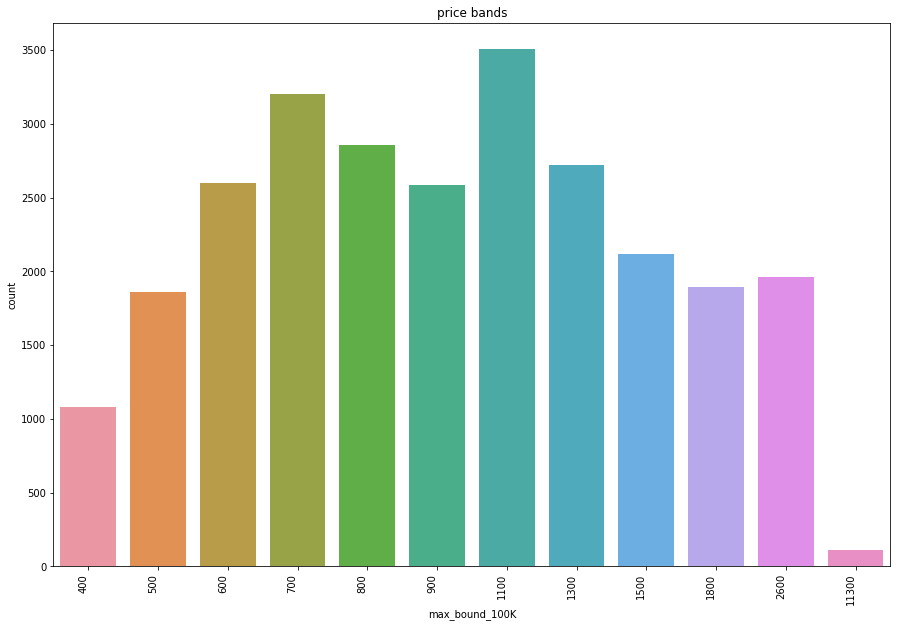

In [6]:
plot = sns.countplot(data_copy['max_bound_100K'])
plot.set_title("price bands")
plot.set_xticklabels(plot.get_xticklabels(), rotation=90, ha="right")
plt.show()

In [0]:
data_copy = data_copy.drop(columns=['price_bands'])

In [0]:
## seperate target and attributes

X = data_copy.drop(columns='max_bound_100K')
Y = data_copy['max_bound_100K']

n_splits = 5
kFold = model_selection.KFold(n_splits=n_splits, shuffle=True)

In [9]:
## encode attributes
X_converted = pd.get_dummies(X)

print("resulting data frame", X_converted.shape)

## encode target
le = preprocessing.LabelEncoder()
le.fit(Y)

Y_converted = le.transform(Y)
max_value = max(Y_converted)
print(max_value)
class_labels = le.inverse_transform(np.arange(max_value + 1))

print(Y_converted)
print(class_labels)

## standadize for use of truncated SVD
scaler = preprocessing.StandardScaler()
scaler.fit(X_converted)

X_converted = scaler.transform(X_converted)

resulting data frame (26505, 754)
11
[ 0  0  0 ... 11 11 11]
[  400   500   600   700   800   900  1100  1300  1500  1800  2600 11300]


In [10]:
### cross validating performance 

accuracies = []
trainIndexList = []
testIndexList = []

for trainIndex, testIndex in kFold.split(X_converted):
  trainIndexList.append(trainIndex)
  testIndexList.append(testIndex)
    
  clf = RandomForestClassifier(n_estimators=350, max_depth=34, max_features='sqrt', min_samples_split=5, min_samples_leaf=2, random_state=42)

  model = clf.fit(X_converted[trainIndex], Y_converted[trainIndex])
  predictions = model.predict(X_converted[testIndex])
  print("accuracy: ")
  accuracy = metrics.accuracy_score(Y_converted[testIndex], predictions)
  print(metrics.accuracy_score(Y_converted[testIndex], predictions))
  accuracies.append(accuracy)
  

accuracy: 
0.38653084323712505
accuracy: 
0.39256744010564043
accuracy: 
0.3857762686285606
accuracy: 
0.39256744010564043
accuracy: 
0.39577438219203925


In [11]:
# find the split that produces the error closest to the average error
best_split = find_nearest(accuracies, np.average(accuracies))

# get the final optimal model using the best split
train_x, test_x = X_converted[trainIndexList[best_split]], X_converted[testIndexList[best_split]]
train_y, test_y = Y_converted[trainIndexList[best_split]], Y_converted[testIndexList[best_split]]

clf = RandomForestClassifier(n_estimators=350, max_depth=34, max_features='sqrt', min_samples_split=5, min_samples_leaf=2, random_state=43)
model = clf.fit(train_x, train_y)

predictions = model.predict(test_x)
print(metrics.accuracy_score(test_y, predictions))

0.39332201471420486


In [12]:
from sklearn.metrics import confusion_matrix
np.set_printoptions(threshold=np.inf)


y_actu = pd.Series(test_y, name='Actual')
y_pred = pd.Series(predictions, name='Predicted')
df_confusion = pd.crosstab(y_actu, y_pred)
df_confusion

Predicted,0,1,2,3,4,5,6,7,8,9,10
Actual,,,,,,,,,,,
0,133,52,15,8,2,1,2,0,0,0,0
1,48,162,106,42,14,1,0,0,0,0,1
2,12,90,194,187,29,4,9,0,0,0,1
3,2,39,128,327,100,15,25,2,2,1,0
4,1,5,33,175,155,53,112,13,4,1,3
5,1,1,8,79,109,68,218,22,6,2,0
6,4,0,6,37,45,44,417,90,22,12,12
7,0,1,0,17,13,9,225,184,54,31,32
8,0,1,1,4,2,5,93,126,79,73,42
